<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/main/notebook/01a_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [24]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
from  xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import sys
import requests 
import io
import warnings
warnings.filterwarnings('ignore')

Check to see if GPU connected. 
It is advised to add GPU from Runtime<Change runtime type<Hardware Accelaration<GPU for faster processing speeds

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importing csv 

In [3]:
table_cohort = pd.read_csv('table_cohort.csv')

In [4]:
table_cohort.describe()

,stay_id,hadm_id,subject_id,age,midodrine,avg_doses_per_24_hrs,los_hospital,los_icu,adm_weekday,weight,...,epi_rate,norepinephrine_use,norepi_rate,phenylephrine_use,phenyl_rate,milrinone_use,mort_28_day,admit_hour,MICU,Gender
count,8.674000e+03,8.674000e+03,8.674000e+03,8674.000000,8674.000000,8674.000000,8674.000000,8674.000000,8674.000000,8498.000000,...,465.000000,6878.0,6878.000000,3864.0,3864.000000,100.0,8674.000000,8674.000000,8674.000000,8674.000000
mean,3.497774e+07,2.502663e+07,1.500673e+07,65.522712,0.098455,1.554209,15.618630,8.015915,3.988241,82.518946,...,0.158489,1.0,0.132138,1.0,1.594022,1.0,0.256975,12.822343,0.628430,0.447890
std,2.896182e+06,2.876491e+06,2.865990e+06,15.851190,0.297946,0.264804,16.022397,8.391177,2.000196,26.824864,...,0.271936,0.0,0.163415,0.0,5.394138,0.0,0.436991,7.462557,0.483252,0.497306
min,3.000048e+07,2.000130e+07,1.000188e+07,18.000000,0.000000,0.806452,1.000000,1.000000,1.000000,1.000000,...,0.010001,1.0,0.010000,1.0,0.020001,1.0,0.000000,0.000000,0.000000,0.000000
25%,3.242515e+07,2.257122e+07,1.255871e+07,56.000000,0.000000,1.373737,6.000000,2.710000,2.000000,65.400000,...,0.040038,1.0,0.058011,1.0,0.657065,1.0,0.000000,6.000000,0.000000,0.000000
50%,3.499144e+07,2.504838e+07,1.501399e+07,67.000000,0.000000,1.525000,11.000000,5.000000,4.000000,78.000000,...,0.075199,1.0,0.096937,1.0,1.036963,1.0,0.000000,15.000000,1.000000,0.000000
75%,3.749099e+07,2.752799e+07,1.746052e+07,77.000000,0.000000,1.700000,20.000000,10.250000,6.000000,95.000000,...,0.136470,1.0,0.166468,1.0,1.984483,1.0,1.000000,19.000000,1.000000,1.000000
max,3.999923e+07,2.999910e+07,1.999984e+07,102.000000,1.000000,4.580000,467.000000,101.750000,7.000000,833.000000,...,2.389600,1.0,6.399658,1.0,298.685819,1.0,1.000000,23.000000,1.000000,1.000000


In [5]:
table_cohort['vaso_starttime'] = pd.to_datetime(table_cohort['vaso_starttime'])
table_cohort['vaso_endtime'] = pd.to_datetime(table_cohort['vaso_endtime'])
table_cohort['vaso_exclude_starttime'] = pd.to_datetime(table_cohort['vaso_exclude_starttime'])
table_cohort['vaso_exclude_endtime'] = pd.to_datetime(table_cohort['vaso_exclude_endtime'])
table_cohort['icu_intime'] = pd.to_datetime(table_cohort['icu_intime'])
table_cohort['icu_outtime'] = pd.to_datetime(table_cohort['icu_outtime'])

table_cohort['english'] = table_cohort['language'].str.contains('english', case=False).astype(np.int32)
table_cohort.drop(['language'], axis=1, inplace=True)

In [7]:
table_cohort['vaso_duration'] = ((table_cohort['vaso_endtime'] - table_cohort['vaso_starttime']).dt.total_seconds() / 3600) # converting secs to hrs
table_cohort['vaso_exclude_duration'] = ((table_cohort['vaso_exclude_endtime'] - table_cohort['vaso_exclude_starttime']).dt.total_seconds() / 3600)

In [8]:
table_cohort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8674 entries, 0 to 8673
Data columns (total 88 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   stay_id                 8674 non-null   int64         
 1   hadm_id                 8674 non-null   int64         
 2   subject_id              8674 non-null   int64         
 3   age                     8674 non-null   int64         
 4   ethnicity               8674 non-null   object        
 5   midodrine               8674 non-null   int64         
 6   avg_doses_per_24_hrs    8674 non-null   float64       
 7   icu_intime              8674 non-null   datetime64[ns]
 8   icu_outtime             8674 non-null   datetime64[ns]
 9   los_hospital            8674 non-null   int64         
 10  los_icu                 8674 non-null   float64       
 11  adm_weekday             8674 non-null   int64         
 12  weight                  8498 non-null   float64 

In [9]:
table_cohort

,stay_id,hadm_id,subject_id,age,ethnicity,midodrine,avg_doses_per_24_hrs,icu_intime,icu_outtime,los_hospital,...,vaso_endtime,vaso_exclude_starttime,vaso_exclude_endtime,mort_28_day,admit_hour,MICU,Gender,english,vaso_duration,vaso_exclude_duration
0,36014877,27162817,11861017,87,WHITE,1,1.605166,2189-03-15 15:48:40,2189-05-01 01:33:42,52,...,2189-04-20 11:48:00,2189-04-07 12:00:00,2189-04-09 06:10:00,0,15,0,0,1,311.800000,42.166667
1,32272859,25963696,11259141,60,WHITE,1,1.594406,2184-07-10 18:39:19,2184-08-03 18:51:35,34,...,2184-07-28 13:02:00,2184-07-10 19:04:00,2184-07-28 13:02:00,0,18,0,1,1,425.966667,425.966667
2,37039117,21396430,10184327,89,WHITE,1,1.087500,2138-10-20 20:25:00,2138-11-01 04:40:00,12,...,2138-10-28 11:55:00,NaT,NaT,1,20,1,0,1,183.250000,NaN
3,34023828,21782431,18010960,59,UNKNOWN,1,1.719512,2167-04-26 15:52:00,2167-05-15 14:29:56,22,...,2167-05-08 07:24:00,2167-04-26 15:30:00,2167-05-07 00:32:00,0,15,0,0,1,279.900000,249.033333
4,32309766,29272306,15703353,59,WHITE,1,1.523810,2181-05-18 03:10:39,2181-05-26 23:37:40,17,...,2181-05-23 08:44:00,2181-05-18 09:20:00,2181-05-23 08:44:00,0,3,0,1,1,119.400000,119.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8669,39690469,21320524,18098524,89,WHITE,0,1.644444,2120-10-30 21:30:12,2120-11-02 18:50:45,7,...,2120-10-31 22:14:00,NaT,NaT,0,21,1,1,1,19.133333,NaN
8670,39696826,24727163,10070932,37,WHITE,0,1.571429,2146-05-11 20:27:00,2146-05-13 09:54:29,5,...,2146-05-12 15:01:00,NaT,NaT,0,20,1,1,1,18.016667,NaN
8671,39801252,24096764,16749537,76,WHITE,0,1.389831,2127-09-10 00:31:00,2127-09-11 18:51:49,11,...,2127-09-11 08:00:00,NaT,NaT,0,0,1,0,1,30.650000,NaN
8672,39838873,20342520,15554479,49,ASIAN,0,1.550000,2183-03-26 10:18:00,2183-03-27 21:53:30,4,...,2183-03-26 11:13:00,NaT,NaT,0,10,1,0,1,0.833333,NaN


In [10]:
mido_data = table_cohort.loc[table_cohort['midodrine'] == 1]
nomido_data = table_cohort.loc[table_cohort['midodrine'] == 0]

## EDA

In [11]:
vaso_start_day_mid = (mido_data['vaso_starttime'] - mido_data['icu_intime']).dt.days
vaso_start_day_nomid = (nomido_data['vaso_starttime'] - nomido_data['icu_intime']).dt.days

In [15]:
vaso_exclude_start_day_mid = (mido_data['vaso_exclude_starttime'] - mido_data['icu_intime']).dt.days
vaso_exclude_start_day_nomid = (nomido_data['vaso_exclude_starttime'] - nomido_data['icu_intime']).dt.days

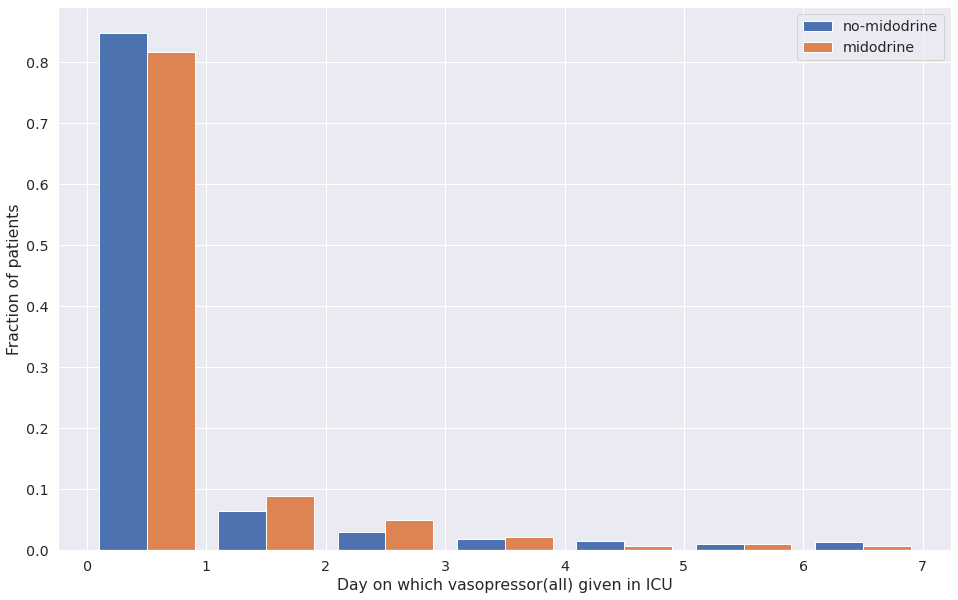

<Figure size 1080x1080 with 0 Axes>

In [18]:
plt.hist([vaso_start_day_nomid, vaso_start_day_mid], bins = [0,1,2,3,4,5,6,7], label=['no-midodrine', 'midodrine'], density=True)
plt.legend(loc='upper right')
plt.xlabel("Day on which vasopressor(all) given in ICU")
plt.ylabel("Fraction of patients")
plt.figure(figsize=(15,15))
plt.show()

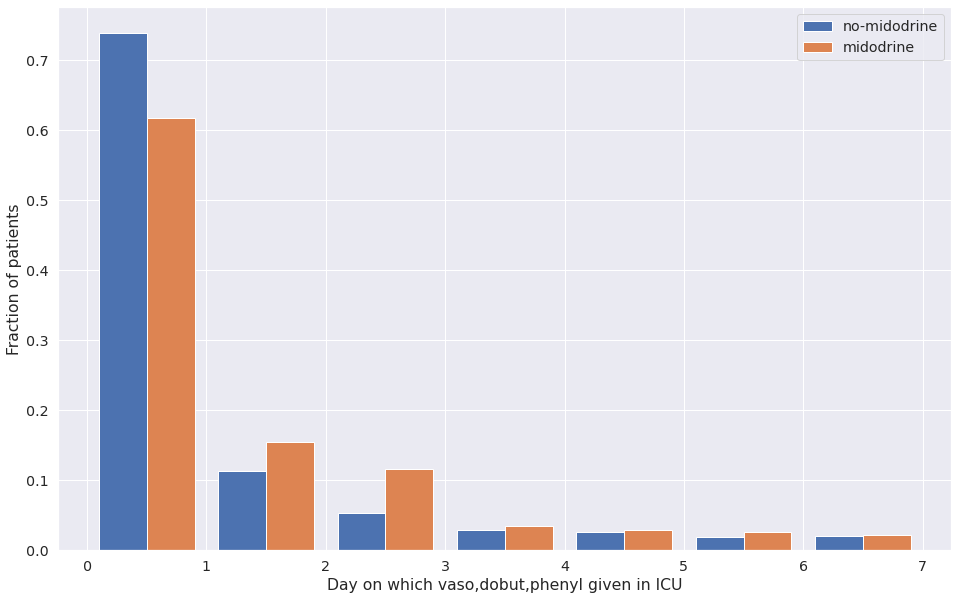

<Figure size 1080x1080 with 0 Axes>

In [17]:
plt.hist([vaso_exclude_start_day_nomid, vaso_exclude_start_day_mid], bins = [0,1,2,3,4,5,6,7], label=['no-midodrine', 'midodrine'], density=True)
plt.legend(loc='upper right')
plt.xlabel("Day on which vaso,dobut,phenyl given in ICU")
plt.ylabel("Fraction of patients")
plt.figure(figsize=(15,15))
plt.show()

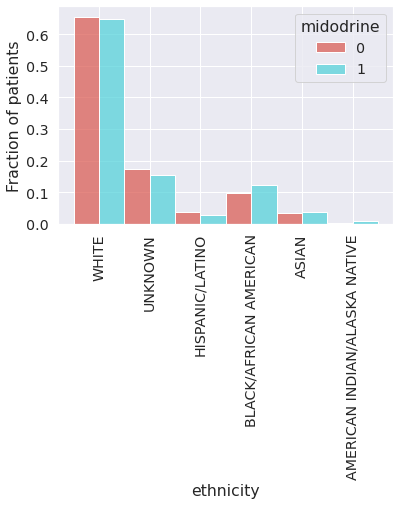

<Figure size 1080x1080 with 0 Axes>

In [ ]:
sns.histplot(x = table_cohort['ethnicity'], hue=table_cohort['midodrine'], palette='hls', multiple="dodge", stat = 'density', common_norm=False)
plt.xticks(rotation = 90) 
plt.ylabel("Fraction of patients")
plt.figure(figsize=(15,15))
plt.show()

In [27]:
mid_vaso_before = pd.read_csv('mid_vaso_before.csv')
mid_vaso_after = pd.read_csv('mid_vaso_after.csv')

In [28]:
mid_vaso_before.describe()

,stay_id,norepi_rate,phenyl_rate,dopa_rate,epi_rate,pressin_rate,dobut_rate
count,6.010000e+02,439.000000,157.000000,20.000000,1.000000,74.000000,5.000000
mean,3.495440e+07,0.087487,1.114923,5.424010,0.028887,2.147602,7.753552
std,2.911337e+06,0.090447,1.034050,3.231422,NaN,0.405152,3.878194
min,3.004562e+07,0.011501,0.130921,1.000307,0.028887,1.198801,5.000020
25%,3.226693e+07,0.039987,0.479891,3.281884,0.028887,1.825335,5.009123
50%,3.504764e+07,0.061172,0.756946,4.629059,0.028887,2.400000,7.011403
75%,3.730378e+07,0.106797,1.420919,7.442233,0.028887,2.401203,7.336132
max,3.998678e+07,1.161890,7.802281,14.012853,0.028887,2.724206,14.411081


In [29]:
mid_vaso_after.describe()

,stay_id,norepi_rate,phenyl_rate,dopa_rate,epi_rate,pressin_rate,dobut_rate
count,6.880000e+02,563.000000,229.000000,34.000000,28.000000,189.000000,16.000000
mean,3.505213e+07,0.103635,1.748957,6.983536,0.244053,2.824692,6.122449
std,2.885267e+06,0.090620,2.601219,5.473110,0.420419,6.899789,4.081389
min,3.004562e+07,0.010001,0.103245,1.500285,0.010001,1.171454,1.900151
25%,3.248574e+07,0.043601,0.594498,3.394328,0.049918,2.000000,2.938440
50%,3.520661e+07,0.074009,1.117028,5.116973,0.097058,2.400000,4.980934
75%,3.736813e+07,0.130020,2.559123,9.293521,0.257742,2.401803,8.548457
max,3.998678e+07,0.599777,35.142064,23.429809,2.059225,94.950000,16.460290


### Feature importance

In [19]:
X = table_cohort.drop(['subject_id', 'hadm_id', 'stay_id', 'ethnicity', 'mort_28_day', 'midodrine', 'avg_doses_per_24_hrs', 'icu_intime', 'icu_outtime',
                       'los_hospital', 'los_icu', 'vasopressin_use', 'pressin_starttime', 'pressin_endtime',
                       'pressin_rate', 'dobutamine_use', 'dobut_starttime', 'dobut_endtime',
                       'dobut_rate', 'dopamine_use', 'dopa_starttime', 'dopa_endtime',
                       'dopa_rate', 'epinephrine_use', 'epi_starttime', 'epi_endtime',
                       'epi_rate', 'norepinephrine_use', 'norepi_starttime', 'norepi_endtime',
                       'norepi_rate', 'phenylephrine_use', 'phenyl_starttime',
                       'phenyl_endtime', 'phenyl_rate', 'milrinone_use', 'vaso_starttime',
                       'vaso_exclude_starttime', 'vaso_exclude_endtime',
                       'vaso_endtime'], axis=1)

y = table_cohort['midodrine']

In [20]:
seed = 20220614 #for reproducible results
test_size=0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [21]:
#instantiate model and train
model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=300)

In [22]:
# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.72%


In [23]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    model = XGBClassifier(n_estimators=300, learning_rate=learning_rate, max_features=2, max_depth=5, random_state=seed)
    model.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(model.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(model.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.991
Accuracy score (validation): 0.937
Learning rate:  0.075
Accuracy score (training): 0.999
Accuracy score (validation): 0.939
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.939
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.939
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.935
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.935
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.941


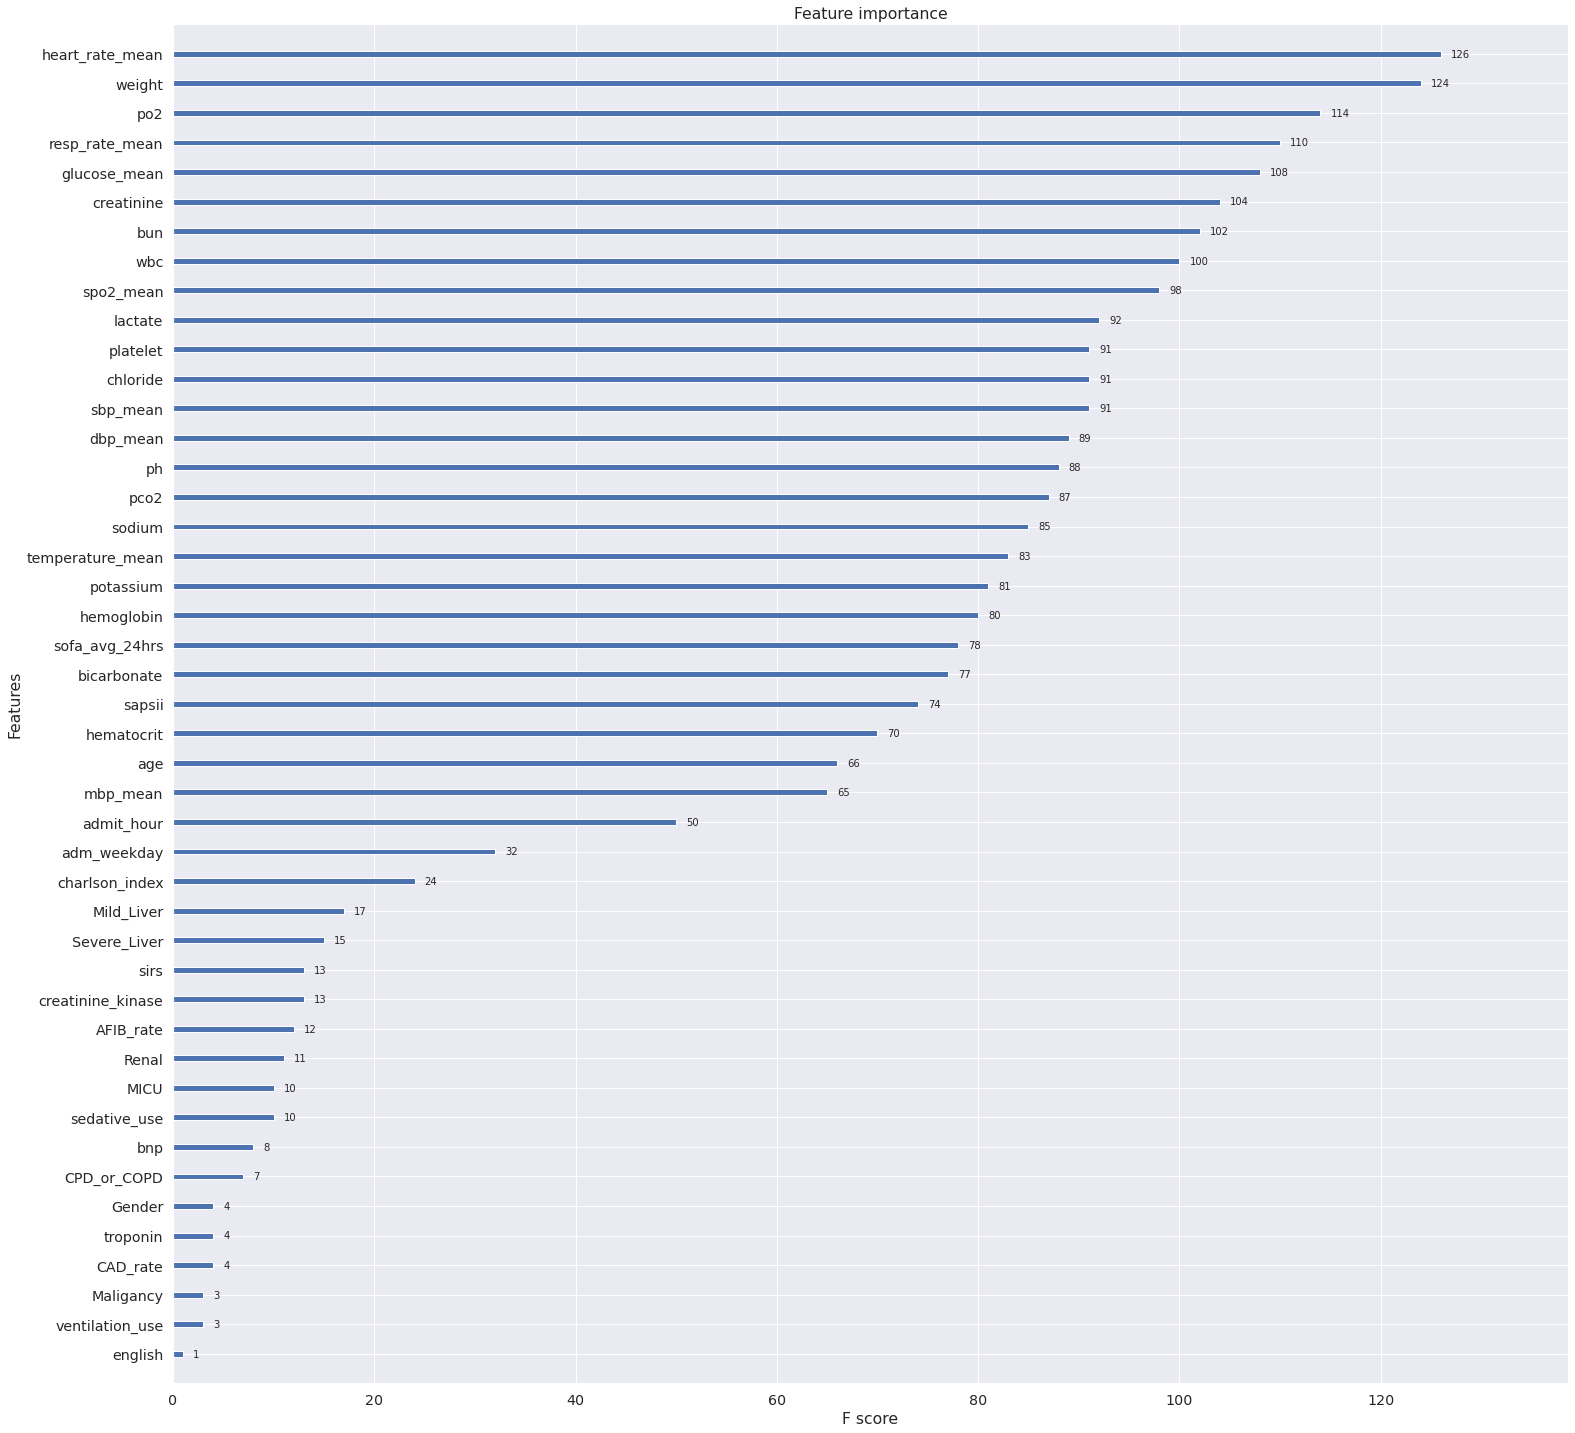

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
fig, ax = plt.subplots(figsize=(25,25))
plot_importance(model, ax=ax)
plt.show()